# Titanic dataset
W tym notebook'u postaram się wytrenować model, który będzie w stanie odgadnąć, czy dana osoba przeżyła katastrofę Titanic'a na podstawie różnych danych na temat tej osoby.

## 1. Importowanie zależności
Żeby wykonać to zadanie, będę potrzebował kilku zależności, takich jak pandas, numpy, czy matplotlib (żeby zwizualizować dane)

In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from stringcase import snakecase

%matplotlib inline

## 2. Załadowanie danych
Aby załadować potrzebne mi dane, posłużę się danymi udostępnionymi przez [Kaggle](https://www.kaggle.com/c/titanic/data). Ładuję jedynie dane treningowe, ponieważ dla danych testowych, Kaggle nie podaje nam target feature (o to chodzi w konkursie). W dalszej części podzielę dane treningowe na 2 zbiory, żeby móc zwalidować model.

In [2]:
train = pd.read_csv('train.csv')

## 3. Zdefiniowanie natury problemu
W tym przypadku nasz problem ma dosyć jasną metrykę sukcesu. Chcemy **zaklasyfikować** każdego z pasażerów jako osobę, która przeżyła katastrofę lub która nie przeżyła. Jest to klasyfikacja binarna.

## 4. Eksploracja danych
Jeżeli mamy już zdefiniowany problem oraz potrzebne dane, to warto by było bliżej im się przyjrzeć, żeby wiedzieć, z czym będziemy pracować.

In [3]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
434,435,0,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
561,562,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S
592,593,0,3,"Elsbury, Mr. William James",male,47.0,0,0,A/5 3902,7.2500,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
122,123,0,2,"Nasser, Mr. Nicholas",male,32.5,1,0,237736,30.0708,NaN,C
751,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S


Oprócz oczywistych danych, takich jak `PassengerId, Survived, Name, etc.`, znajduje się kilka bardziej "tajemniczych" nazw kolumn. Sprawdzając to na Kaggle, dowiadujemy się, że:

***pclass*** - jest to oznaczenie klasy socjo-ekonomicznej danego pasażera, gdzie:
    - 1 = klasa wyższa
    - 2 = klasa średnia
    - 3 = klasa niższa
    
***parch*** - oznacza relację rodzić-dziecko (innymi słowy, w przypadku dorosłego, z iloma dziećmi podróżował, a w przypadku dzieci - ilu rodziców podróżowało z tym dzieckiem. Niektóre dzieci podróżowały z opiekunkami - dla nich wartość tej kolumny wynosi 0)

***sibsp*** - oznacza relację rodzeństwo-małżonek/małżonka (podobnie jak w przypadku parch). Narzeczeni lub "nieformalni" partnerzy nie byli brani pod uwagę.

***embarked*** - nazwa portu, z którego dany pasażer wyruszył w podróż (C = Cherbourg, Q = Queenstown, S = Southampton)


Sprawdźmy nasze dane nieco dokładniej

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Najistotniejszą rzeczą, którą można wywnioskować z powyższych informacji jest to, że mamy puste wartości w kolumnach **Age** i **Cabin**. Rozwiążemy tę sytuację podstawiając w miejsce pustych wartości *-1*.

In [37]:
train.fillna(-1, inplace=True)
train.sample(10)

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
667,668,0,3,"Rommetvedt, Mr. Knud Paust",male,-1.0,0,0,312993,7.7750,-1,S
559,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,-1,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,-1,S
681,682,1,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
231,232,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,-1,S
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,-1.0,0,0,111427,26.5500,-1,S
761,762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.1250,-1,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,-1,S


Jak widać powyżej - puste wartości zostały zatąpione przez *-1*. W ten sposób model nie pomyli ich z innymi wartościami dostępnymi w tym dataset'cie

Wygodniej by było, gdybyśmy jeszcze ustandaryzowali sobie nazwy kolumn. Zamieńmy nazwy kolumn w dataset'cie z `camelCase` na `snake_case`. Wykorzystam do tego bibliotekę `stringcase`, którą wcześniej zainstalowałem za pomocą komendy `pip install stringcase`

In [7]:
train.rename(columns=lambda x: snakecase(x), inplace=True)

In [8]:
train.sample()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
325,326,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C


## Wizualizacja

Warto zbadać dane "wzrokowo", posługując się wykresami. Często w ten sposób dużo łatwiej wychwycić ciekawe zależności. Na początek sprawdźmy jak wyglądał rozkład ocalałych pasażerów, biorąc pod uwagę ich płeć.

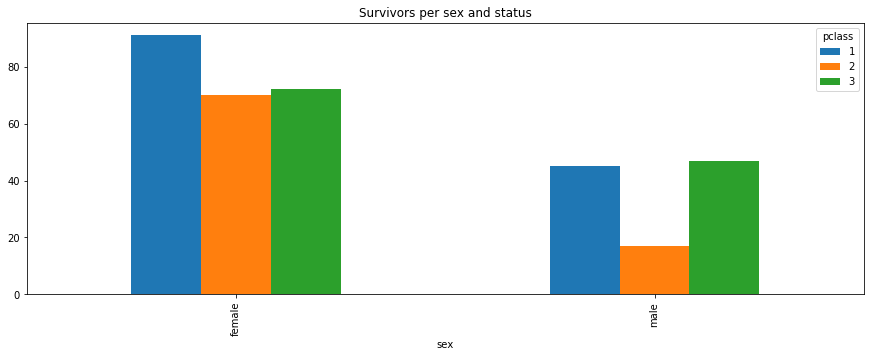

In [27]:
survivors = train[train['survived'] == 1]
grouped = survivors.groupby(['sex', 'pclass'])['survived'].agg('sum').unstack()
grouped.plot(kind='bar', figsize=(15, 5), title='Survivors per sex and status');

Na pierwszy rzut oka widzimy, że wśród ocalałych pasażerów, większość stanowią kobiety. Co ciekawe - nasuwa się również obserwacja, że w przypadku kobiet, należność do wyższej klasy społecznej również miała wpływ na ich szanse na przeżycie katastrofy. W przypadku mężczyzn proporcje ocalałych biorąc pod uwagę klasę społeczną nie miały większego znaczenia, z wyjątkiem panów należących do klasy śreniej.

Pojawia się jednak pewna wątpliwość - widzimy proporcje ocalałych ze względu na płeć, ale wyciągnięcie pochopnych wniosków mogłoby być zniekształcaniem rzeczywistości. Co jeżeli większość pasażerów na Tytanic'u generalnie stanowiły kobiety? Sprawdźmy to.

In [41]:
train['sex'].value_counts()

male      577
female    314
Name: sex, dtype: int64

Jak widać, w większości pasażerami byli mężczyźni. Skąd więc taka dysproporcja wśród ocalałych? Moja teza jest taka, że o takiej statystyce zadecydowała zasada "najpierw kobiety i dzieci" oraz skłonność mężczyzn do ustępowania kobietom lepszych miejsc (jak chociażby Jack w filmie ;)). Skoro wspomnieliśmy o dzieciach, to z ciekawości sprawdźmy również jak wyglądała sprawa biorąc pod uwagę wiek.

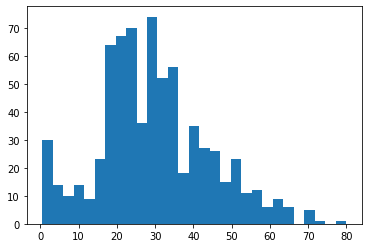

In [50]:
plt.hist(train['age'][train['age'] >= 0], bins=29);

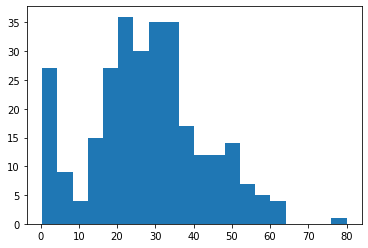

In [51]:
plt.hist(survivors['age'][survivors['age'] >= 0], bins=20);

Patrząc na dwa powyższe histogramy, rzeczywiście widać, że przeżyło relatywnie dużo noworodków i dzieci do 10-tego roku życia. Patrząc na pozostałe przedziały, proporcja wszystkich pasażerów do tych, którzy przeżyli wygląda dosyć równomiernie.

Kolejną cechą, która przykuwa moją uwagę jest relacja parent-child. Czy posiada

## 5. Standaryzowanie danych i feature engineering

## 6. Podział danych i trenowanie modelu

In [ ]:
X = train.drop('survived', axis=1)
y = train['survived']
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)